### 4. LATENT DIRICHLET ALLOCATION

Latent Dirichlet Allocation (LDA) is an unsupervised machine learning algorithm used to identify topics within a body of text.  In this case, I'm using LDA with a corpuso of ICD-10 codes from the underlying and multiple cause fields to see if the algorithm can separate the records into a predetermined number of causes of death.

LDA works by assuming each document (series of ICD-10 code for each death record) is comprised of multiple topics with some topics being more dominant.  Each topic is made up of key words, again, with certain words within each topic being more dominant. 

When I specify the number of topics I want the algorithm to find it classifies records into the specified number of topics by rearranging words within topics and topics within documents to reach the best groupings of records. 

In this section, I used LDA with three versions of the ICD-10 corpus and compared their performance based on a 'coherence score' to determine which type of corpus provides the algorithm the most information. In addition to examining relative performance, I also looked at the most salient codes in each topic to see if the clustering made sense in terms of conditions might co-occur on death records.

In [1]:
import re
import ast
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS

from collections import Counter

# nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from tokenize import tokenize

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')


**Load data**

In [2]:
ds = pd.read_csv(r'Y:/DQSS/Death/MBG/py/capstone2/data/d1619_clean.csv',
                low_memory=False)

In [3]:
ds.gc_cat.value_counts()

0    211924
6      3868
5      2973
2      2767
3      2376
1      2149
4       534
8       368
9        38
Name: gc_cat, dtype: int64

**Keep records with garbage underlying cause codes**

In [4]:
ds = ds.loc[ds['gc_cat']!=0, :]
len(ds)

15073

In [5]:
ds.head()

,sfn,sex,dody,dcounty,hispanic,race,agegrp,manner,tobac,pg,gc_cat,gc_cat_label,UCOD,MC2,AllMC,MC2_20,codlit,cert_label
3,2017025190,F,2017,KING,No,White,80+ yrs,N,N,8.0,4,4-Volume depletion,E86,N179,E86 N179 R13,N179 R13,ACUTE RENAL FAILURE DEHYDRATION DYSPHAGIA,1-Physician
4,2017025191,M,2017,SPOKANE,No,White,70-79 yrs,N,Y,8.0,4,4-Volume depletion,E870,F54,E870 F54 G729 I509 J969 R093 R418 R53 T179 W80...,F54 G729 I509 J969 R093 R418 R53 T179 W80 ...,PULSELESS ELECTRICAL ACTIVITY ARREST HYPOXEMIC...,1-Physician
12,2017019369,F,2017,PIERCE,No,White,80+ yrs,N,N,8.0,2,2-Heart failure,I500,NaN,I500,,PROBABLE CONGESTIVE HEART FAILURE HOSPICE,1-Physician
30,2017014601,F,2017,KING,No,White,70-79 yrs,N,N,8.0,1,1-Septicemia,A419,I469,A419 I469 R092,I469 R092,"RESPIRATORY AND CARDIAC ARREST SEVERE SEPSIS, ...",1-Physician
38,2017025200,F,2017,SNOHOMISH,No,White,80+ yrs,N,N,8.0,2,2-Heart failure,I500,D469,I500 D469 I802 J189 T828 Y831,D469 I802 J189 T828 Y831,"CONGESTIVE HEART FAILURE, CAUSE NOT FORMALLY W...",1-Physician


**Tokenize text and create 3 versions of the corpus**

The three versions of the ICD-10 corpus are:

1. Short ICD-10 unigrams without garbage codes in any multiple cause field
2. Short ICD-10 unigrams with garbage codes
3. Short ICD-10 bigrams without garbage codes in any multiple cause field

In [6]:
## call stored object 'gc_all' created in 2_PrepData_ICD10.ipynb.  Will only work if you run that notebook first.
%store -r gc_all  
# add 'respiratory failure' codes to the list of stopwords
respfail_tobac_codes = ['J960','J961','J969','F179']
gc_plus = gc_all + respfail_tobac_codes

In [7]:
from myfunction_2 import make_corpi
ds['clean_mc'], ds['short_mc'], ds['clean_mcgc'] = make_corpi(ds['AllMC'], gc_plus)

In [8]:
def make_bigrams(doc):
    bi = []
    for i in range(len(doc)-1):
        bigrm = doc[i] + "_" + doc[i+1]
        bi.append(bigrm)
    return bi

In [9]:
# short code bigrams
ds['bigrams'] = ds.loc[:,'short_mc'].apply(lambda row: make_bigrams(row))

In [10]:
#long code bigrams
ds['bigrams_long'] = ds.loc[:,'clean_mc'].apply(lambda row: make_bigrams(row))

In [11]:
ds.head()

,sfn,sex,dody,dcounty,hispanic,race,agegrp,manner,tobac,pg,...,MC2,AllMC,MC2_20,codlit,cert_label,clean_mc,short_mc,clean_mcgc,bigrams,bigrams_long
3,2017025190,F,2017,KING,No,White,80+ yrs,N,N,8.0,...,N179,E86 N179 R13,N179 R13,ACUTE RENAL FAILURE DEHYDRATION DYSPHAGIA,1-Physician,[N179],[N17],"[E86, N17, R13]",[],[]
4,2017025191,M,2017,SPOKANE,No,White,70-79 yrs,N,Y,8.0,...,F54,E870 F54 G729 I509 J969 R093 R418 R53 T179 W80...,F54 G729 I509 J969 R093 R418 R53 T179 W80 ...,PULSELESS ELECTRICAL ACTIVITY ARREST HYPOXEMIC...,1-Physician,"[F54, G729, W80]","[F54, G72, W80]","[E87, F54, G72, I50, J96, R09, R41, R53, T17, ...","[F54_G72, G72_W80]","[F54_G729, G729_W80]"
12,2017019369,F,2017,PIERCE,No,White,80+ yrs,N,N,8.0,...,NaN,I500,,PROBABLE CONGESTIVE HEART FAILURE HOSPICE,1-Physician,[],[],[I50],[],[]
30,2017014601,F,2017,KING,No,White,70-79 yrs,N,N,8.0,...,I469,A419 I469 R092,I469 R092,"RESPIRATORY AND CARDIAC ARREST SEVERE SEPSIS, ...",1-Physician,[],[],"[A41, I46, R09]",[],[]
38,2017025200,F,2017,SNOHOMISH,No,White,80+ yrs,N,N,8.0,...,D469,I500 D469 I802 J189 T828 Y831,D469 I802 J189 T828 Y831,"CONGESTIVE HEART FAILURE, CAUSE NOT FORMALLY W...",1-Physician,"[D469, I802, J189, Y831]","[D46, I80, J18, Y83]","[I50, D46, I80, J18, T82, Y83]","[D46_I80, I80_J18, J18_Y83]","[D469_I802, I802_J189, J189_Y831]"


In [12]:
 # to remove rows with empty lists in 'clean_mc' column.
ds = ds[ds.clean_mc.astype(bool)]
len(ds)

7797

**CONSTRUCT DICTIONARY**

In this step I create dictionaries for each version of the corpus.  A dictionary is a pairing of each unique word with a unique ID.  It is a necessary precursor for the LDA algorithm.

In [13]:
'''create dictionary for later use and also create bag of words - prune words that occur in 5 or fewer records
or more than 50% of records'''

dictionary_uni_short = gensim.corpora.Dictionary(ds.short_mc)
dictionary_uni_short.filter_extremes(no_below=5, no_above=0.5)

dictionary_uni_long = gensim.corpora.Dictionary(ds.clean_mc)
dictionary_uni_long.filter_extremes(no_below=5, no_above=0.65)

dictionary_bi = gensim.corpora.Dictionary(ds.bigrams)
dictionary_bi.filter_extremes(no_below=5, no_above=0.5)

dictionary_bi_long = gensim.corpora.Dictionary(ds.bigrams_long)
dictionary_bi_long.filter_extremes(no_below=5, no_above=0.5)

Below is a print out of the first 11 ID-word pairs to show the contents of one of the dictionaries.

In [14]:
count = 0
for k, v in dictionary_uni_short.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 N17
1 W80
2 D46
3 I80
4 J18
5 Y83
6 B18
7 C78
8 I12
9 I48
10 J44


The length of each of the dictionaries is relatively short indicating that the 'vocabulary' (ICD-10 codes) is not varied.

In [15]:
len(dictionary_uni_short),len(dictionary_uni_long),len(dictionary_bi),len(dictionary_bi_long)

(245, 360, 361, 284)

**Construct bag of words for each corpus**

Another precursor step is to convert the ICD-10 codes into a 'bag of words' which is esssentially the collection of words in a given text without regard to the order of the words or the grammar but including each word as many time as it occurs in a given text.

In [16]:
'''bag of words - for each document there is now a dictionary.  
Word counts can be figured out using these with BOW.'''

bow_corpus_uni_short = [dictionary_uni_short.doc2bow(doc) for doc in ds.short_mc]
bow_corpus_uni_long = [dictionary_uni_long.doc2bow(doc) for doc in ds.clean_mc]
bow_corpus_bi = [dictionary_bi.doc2bow(doc) for doc in ds.bigrams]
bow_corpus_bi_long = [dictionary_bi_long.doc2bow(doc) for doc in ds.bigrams_long]

**Create TF-IDF for each corpus**

The text (ICD-10 codes) in the corpus cannot be used directly for modeling and need to be converted into a vector of numbers.  TF-IDF is a calculation that captures the frequency of each word (in this case ICD-10 codes) within the document and also across all documents in the data set.  These values are provided to models for use in classification.

In [17]:
from gensim import corpora, models

tfidf_uni_short = models.TfidfModel(bow_corpus_uni_short)
corpus_uni_short = tfidf_uni_short[bow_corpus_uni_short]

tfidf_uni_long = models.TfidfModel(bow_corpus_uni_long)
corpus_uni_long = tfidf_uni_long[bow_corpus_uni_long]

tfidf_bi = models.TfidfModel(bow_corpus_bi)
corpus_bi = tfidf_bi[bow_corpus_bi]

tfidf_bi_long = models.TfidfModel(bow_corpus_bi_long)
corpus_bi_long = tfidf_bi_long[bow_corpus_bi_long]

For each of the LDA models I built I specified that the algorithm should find 6 topics. I also kept other parameters constant so that I could compare models. In earlier LDA models with a corpus consisting of ICD-10 codes including garbage codes I found that the models performed relatively poorly compared with models that used a corpus without garbage codes.  It is likely that the frequently occuring garbage code obscured any meaningful information that might have helped the algorithm distinguish between topics. This analysis examines the performance of LDA using corpora with different combinations of ngrams and ICD-code length.

**LDA MODEL WITH UNIGRAMS AND SHORT ICD-10 CODES EXCLUDING GARBAGE CODES**

In this version of the model I use unigrams (single ICD-10 codes) in their abridged form i.e. without the fourth character. The reason for using this version of ICD-10 codes is to try to group together records that share the same 'root' because in many instances the fourth character adds a level of detail to the cause of death that may not be helpful to the algorithm.  In a way, the exclusion of the last character is analogous to removing word endings like 'ed' or 'ing' and keeping just the root.

In [18]:
ldamodel_all_uni_short = gensim.models.LdaMulticore(corpus_uni_short,
                                              id2word=dictionary_uni_short,
                                              num_topics=6,
                                              passes=30,
                                              alpha = 0.5,
                                              eta = 0.1,
                                              workers=4,
                                              random_state=55
                                             )

In [19]:
for idx, topic in ldamodel_all_uni_short.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx,topic))

Topic: 0 
Words: 0.132*"F01" + 0.102*"E66" + 0.099*"J69" + 0.074*"I64" + 0.045*"F19" + 0.043*"I12" + 0.042*"E46" + 0.033*"K70" + 0.031*"K76" + 0.030*"F17"
Topic: 1 
Words: 0.159*"C78" + 0.123*"C79" + 0.104*"E11" + 0.078*"I25" + 0.051*"F10" + 0.044*"J90" + 0.037*"J81" + 0.030*"J80" + 0.024*"I80" + 0.023*"I47"
Topic: 2 
Words: 0.183*"I48" + 0.174*"J44" + 0.144*"E14" + 0.090*"G30" + 0.073*"N19" + 0.070*"N28" + 0.057*"I71" + 0.032*"J98" + 0.024*"Y83" + 0.021*"G31"
Topic: 3 
Words: 0.219*"N17" + 0.075*"I21" + 0.066*"K72" + 0.054*"G47" + 0.045*"I35" + 0.043*"I69" + 0.038*"K56" + 0.032*"I63" + 0.030*"J84" + 0.027*"F32"
Topic: 4 
Words: 0.171*"F03" + 0.161*"J18" + 0.119*"E78" + 0.051*"K92" + 0.050*"I45" + 0.040*"K74" + 0.039*"D64" + 0.031*"I42" + 0.030*"E03" + 0.029*"G20"
Topic: 5 
Words: 0.185*"N18" + 0.162*"A49" + 0.161*"G93" + 0.074*"N39" + 0.059*"I73" + 0.049*"I95" + 0.034*"W80" + 0.030*"J15" + 0.016*"I44" + 0.015*"G45"


In [20]:
coherence_ldamodel_all_uni_short = CoherenceModel(model = ldamodel_all_uni_short, 
                                      texts = ds.short_mc, 
                                      dictionary = dictionary_uni_short, 
                                      coherence = 'c_v')

coherence_ldamodel_all_uni_short = coherence_ldamodel_all_uni_short.get_coherence()

print("Coherence score for LDA model: short ICD-10 unigrams, 6 topics, 30 passes: ", coherence_ldamodel_all_uni_short)


Coherence score for LDA model: short ICD-10 unigrams, 6 topics, 30 passes:  0.49322028766626236


This LDA model had a coherence score of 0.49 (out of a range of 0 to 1 with 1 being the best score).  The coherence score provides an estimate of the similarity or relative distance of ICD-10 codes in each topic. Based on the experience of other NLP practitioners, it would seem that achieving a score of 0.7 is a good goal and that 0.9 is very unlikely to happen unless words are identical.



In [21]:
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis
pyLDAvis.enable_notebook()
ldamodel_all_uni_short_vis = pyLDAvis.gensim.prepare(ldamodel_all_uni_short, corpus_uni_short, dictionary_uni_short)
ldamodel_all_uni_short_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.281217  0.164902       1        1  17.671196
1     -0.109244 -0.301437       2        1  17.395674
4     -0.217596  0.085939       3        1  17.084148
5      0.087424 -0.157285       4        1  16.046291
0     -0.200687  0.222158       5        1  16.001490
3      0.158886 -0.014277       6        1  15.801209, topic_info=    Term        Freq       Total Category  logprob  loglift
0    N17  384.000000  384.000000  Default  30.0000  30.0000
12   F03  310.000000  310.000000  Default  29.0000  29.0000
20   A49  274.000000  274.000000  Default  28.0000  28.0000
71   G93  273.000000  273.000000  Default  27.0000  27.0000
31   N18  342.000000  342.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
126  J94    8.749540    9.239162   Topic6  -5.2440   1.7906
188  C25    8.497507    8.987881   Topic6  -5.2732   1.7890
0    N17  362.543213  384.472626   Topic6  -1.5198   1.7864
9    I48   21.955292  390.484528   Topic6  -4.3240  -1.0333
10   J44   13.014272  377.659332   Topic6  -4.8469  -1.5229

[233 rows x 6 columns], token_table=      Topic      Freq Term
term                      
79        2  0.986574  A04
184       5  0.967667  A09
20        4  0.993859  A49
20        6  0.003641  A49
6         5  0.989307  B18
...     ...       ...  ...
23        6  0.976226  X59
139       5  0.994591  Y43
137       5  0.994791  Y44
5         1  0.978300  Y83
107       6  0.977391  Y84

[284 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 6, 1, 4])

The plot shows a visualization of the models attempts at finding 6 topics (as I specified).  Optimally, the circles which represent the topics should be separated and larger.  In this instance, we see exactly. Topics 1 has a high occurrence of unspecifed atrial fibrillation (I48) and COPD (J44). Topic 2 is dominated by cancer codes C78 (secondary malignant neoplasm of respiratory and digestive organs) and C79 (secondary malignant neoplasm of organs specified by the 4th character of ICD-10 codes . Topic 3 has higher proportions of unspecified dementia (F03) and bronchopneumonia (J18). Topic 4 is predominantly comprised of chronic kidney disease and unspecified bacterial infection (A49).  Multi-infarct dementia (F01) and obesity (E66) are the most common key terms in topic 5. Finally, in topic 6 acute kidney failure (N17) is the most common term.  

The commonalities between the key phrases in each topic is not very obvious in this model.

**LDA WITH LONG UNIGRAMS EXCLUDING GARBAGE CODES**

In the next version of the model I used full ICD-10 codes as unigrams.

In [22]:
ldamodel_all_uni_long = gensim.models.LdaMulticore(corpus_uni_long,
                                              id2word=dictionary_uni_long,
                                              num_topics=6,
                                              passes=30,
                                              alpha = 0.5,
                                              eta = 0.1,
                                              workers=4,
                                              random_state = 101
                                             )

In [23]:
coherence_ldamodel_all_uni_long = CoherenceModel(model = ldamodel_all_uni_long, 
                                      texts = ds.clean_mc, 
                                      dictionary = dictionary_uni_long, 
                                      coherence = 'c_v')

coherence_ldamodel_all_uni_long = coherence_ldamodel_all_uni_long.get_coherence()

print("Coherence score for LDA model: long ICD-10 unigrams, 6 topics, 30 passes: ", coherence_ldamodel_all_uni_long)

Coherence score for LDA model: long ICD-10 unigrams, 6 topics, 30 passes:  0.5403078647513844


In [24]:
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis
pyLDAvis.enable_notebook()
ldamodel_all_uni_long_vis = pyLDAvis.gensim.prepare(ldamodel_all_uni_long, corpus_uni_long, dictionary_uni_long)
ldamodel_all_uni_long_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.324306 -0.002628       1        1  17.542683
1      0.158162 -0.153682       2        1  17.463009
3      0.205999 -0.110255       3        1  16.657679
2      0.091204  0.034608       4        1  16.144991
5     -0.174012 -0.152314       5        1  16.144505
0      0.042954  0.384271       6        1  16.047134, topic_info=     Term        Freq       Total Category  logprob  loglift
4    J189  385.000000  385.000000  Default  30.0000  30.0000
12    F03  337.000000  337.000000  Default  29.0000  29.0000
0    N179  345.000000  345.000000  Default  28.0000  28.0000
9     I48  384.000000  384.000000  Default  27.0000  27.0000
10   J449  360.000000  360.000000  Default  26.0000  26.0000
..    ...         ...         ...      ...      ...      ...
325   D70    8.836080    9.329704   Topic6  -5.2425   1.7753
241  C794    8.832471    9.328139   Topic6  -5.2429   1.7750
246  J869    9.659695   10.206622   Topic6  -5.1534   1.7746
284  F172   19.080421   20.936871   Topic6  -4.4727   1.7368
88   Y839    9.576203   10.209280   Topic6  -5.1621   1.7656

[228 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
91        2  0.045025  A047
91        5  0.945535  A047
255       4  0.943238  A099
44        4  0.991066  A490
86        4  0.986998  A491
...     ...       ...   ...
341       6  0.977113  X599
178       2  0.934703  Y442
5         4  0.961264  Y831
88        6  0.979501  Y839
320       6  0.968643  Y841

[271 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 6, 1])

Using long ICD-10 codes as unigrams doesn't improve the model coherence score very much at 0.54. Again, it's hard to find commonalities in the terms within each topic.

**LDA WITH SHORT BIGRAMS EXLUDING GARBAGE TERMS**

Next, I tried using bi-grams of short ICD-10 codes.  Adjacent ICD-10 codes in each record are considered as a single unit and provide a little more context when trying to interpret the topics.

In [25]:
ldamodel_bi = gensim.models.LdaMulticore(corpus_bi,
                                              id2word=dictionary_bi,
                                              num_topics=6,
                                              passes=30,
                                              alpha = 0.5,
                                              eta = 0.1,
                                              workers=4,
                                              random_state = 101
                                             )

for idx, topic in ldamodel_bi.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx,topic))


Topic: 0 
Words: 0.109*"N17_N18" + 0.058*"J18_N17" + 0.051*"J44_N18" + 0.038*"G30_I48" + 0.032*"I48_I63" + 0.029*"J18_N28" + 0.026*"G93_J18" + 0.025*"I48_J69" + 0.024*"I35_I48" + 0.021*"I48_N17"
Topic: 1 
Words: 0.056*"I48_J18" + 0.048*"F01_I48" + 0.043*"J18_J80" + 0.042*"E78_F01" + 0.042*"J18_N18" + 0.042*"E66_G47" + 0.029*"K92_N17" + 0.026*"G93_I48" + 0.025*"I48_N18" + 0.025*"E11_F01"
Topic: 2 
Words: 0.083*"I48_J44" + 0.043*"E14_J44" + 0.040*"I48_I64" + 0.036*"F03_J18" + 0.029*"N18_N28" + 0.027*"E14_I25" + 0.025*"E78_F03" + 0.025*"G93_I45" + 0.025*"I25_J44" + 0.019*"A49_G93"
Topic: 3 
Words: 0.166*"C78_C78" + 0.052*"E14_E66" + 0.032*"E11_E66" + 0.031*"E14_I48" + 0.029*"I73_J44" + 0.029*"E66_E78" + 0.029*"J18_J90" + 0.027*"I21_I25" + 0.026*"E11_I48" + 0.026*"C77_C78"
Topic: 4 
Words: 0.180*"C78_C79" + 0.074*"C79_C79" + 0.060*"E14_E78" + 0.040*"I25_I48" + 0.028*"J44_N17" + 0.025*"E11_F03" + 0.024*"N17_N39" + 0.019*"J18_N39" + 0.019*"G47_I48" + 0.019*"K72_N19"
Topic: 5 
Words: 0.060*"F

In [26]:
coherence_ldamodel_bi = CoherenceModel(model = ldamodel_bi, 
                                      texts = ds.bigrams, 
                                      dictionary = dictionary_bi, 
                                      coherence = 'c_v')

coherence_ldamodel_bi = coherence_ldamodel_bi.get_coherence()

print("Coherence score for LDA model: ICD-10 bigrams without garbage code, 6 topics, 30 passes: ", coherence_ldamodel_bi)

Coherence score for LDA model: ICD-10 bigrams without garbage code, 6 topics, 30 passes:  0.7773229832801457


The coherence score for the LDA model built with bigrams and no garbage codes was much higher than either of the two previous models.

In [27]:
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis
pyLDAvis.enable_notebook()
ldamodel_all_bi_vis = pyLDAvis.gensim.prepare(ldamodel_bi, corpus_bi, dictionary_bi)
ldamodel_all_bi_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.268671 -0.179715       1        1  17.260506
2     -0.230041  0.136908       2        1  17.061958
3      0.212624  0.287669       3        1  16.859312
0     -0.074903 -0.230585       4        1  16.479059
1     -0.075138 -0.003953       5        1  16.388569
5     -0.101214 -0.010324       6        1  15.950592, topic_info=        Term        Freq       Total Category  logprob  loglift
6    C78_C79  110.000000  110.000000  Default  30.0000  30.0000
24   C78_C78   99.000000   99.000000  Default  29.0000  29.0000
105  N17_N18   63.000000   63.000000  Default  28.0000  28.0000
3    I48_J44   50.000000   50.000000  Default  27.0000  27.0000
59   C79_C79   44.000000   44.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
258  F10_J44    7.137535    7.606094   Topic6  -4.3526   1.7721
231  J44_K74    6.838503    7.306593   Topic6  -4.3954   1.7695
144  K72_N28    6.618019    7.088412   Topic6  -4.4281   1.7670
114  I80_J44    6.554966    7.021332   Topic6  -4.4377   1.7669
60   F03_F91    6.241200    6.707996   Topic6  -4.4868   1.7635

[215 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
270       3  0.965858  A49_D65
237       6  0.945516  A49_E11
15        3  0.976677  A49_E14
117       1  0.951728  A49_F03
128       2  0.997989  A49_G93
...     ...       ...      ...
105       4  0.980445  N17_N18
76        1  0.928618  N17_N39
62        2  0.952610  N18_N28
74        5  0.954031  N18_N39
38        1  0.987963  N28_N39

[190 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2, 6])

The coherence score is much higher for bigrams compared with unigrams. The key ICD-10 code pairs in each topic appear to cluster together well. Topics 1 and 3 both have high proportions of cancer-related bigrams.  Topic 2 is comprised of atrial fibrillation and COPD while topic 4 has high proportions of acute kidney failure and chronic kidney disease. Finally, topics 5 and 6 have a great deal of overlap which indicates similar key words.  In fact, both topics are dominated by combinations of dementia and atrial fibrillation code combinations.

**LDA WITH LONG BIGRAMS EXLUDING GARBAGE TERMS**

The final model is one with full ICD-10 codes as bi-grams.

In [28]:
ldamodel_bi_long = gensim.models.LdaMulticore(corpus_bi_long,
                                              id2word=dictionary_bi_long,
                                              num_topics=6,
                                              passes=30,
                                              alpha = 0.5,
                                              eta = 0.1,
                                              workers=4,
                                              random_state = 101
                                             )

for idx, topic in ldamodel_bi_long.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx,topic))

Topic: 0 
Words: 0.079*"J189_N179" + 0.072*"I48_J189" + 0.048*"G309_I48" + 0.038*"C795_C798" + 0.037*"C780_C793" + 0.032*"K720_N179" + 0.029*"I48_J440" + 0.027*"J81_N179" + 0.026*"C793_C795" + 0.026*"E669_G473"
Topic: 1 
Words: 0.068*"F03_I48" + 0.048*"F019_I48" + 0.045*"C787_C788" + 0.044*"E149_J449" + 0.042*"C780_C798" + 0.036*"E149_F03" + 0.035*"J449_N179" + 0.033*"G931_I458" + 0.026*"I48_I739" + 0.026*"E149_I48"
Topic: 2 
Words: 0.074*"E149_E785" + 0.072*"I48_I64" + 0.048*"N179_N390" + 0.047*"C780_C795" + 0.038*"E785_F03" + 0.036*"G473_I48" + 0.033*"E785_G473" + 0.032*"I48_N179" + 0.029*"I251_J449" + 0.027*"C786_C787"
Topic: 3 
Words: 0.112*"N179_N189" + 0.058*"I251_I48" + 0.052*"J189_J80" + 0.049*"F03_J189" + 0.040*"J189_J90" + 0.031*"I48_J690" + 0.027*"E119_I48" + 0.026*"E785_J449" + 0.026*"E119_G309" + 0.026*"E039_E785"
Topic: 4 
Words: 0.108*"C780_C787" + 0.071*"C787_C795" + 0.038*"N189_N288" + 0.034*"J189_N288" + 0.030*"E119_F03" + 0.029*"I350_I48" + 0.028*"E669_E785" + 0.026*

In [29]:
coherence_ldamodel_bi_long = CoherenceModel(model = ldamodel_bi_long, 
                                      texts = ds.bigrams_long, 
                                      dictionary = dictionary_bi_long, 
                                      coherence = 'c_v')

coherence_ldamodel_bi_long = coherence_ldamodel_bi_long.get_coherence()

print("Coherence score for LDA model: ICD-10 long bigrams without garbage codes, 5 topics, 30 passes: ", coherence_ldamodel_bi_long)

Coherence score for LDA model: ICD-10 long bigrams without garbage codes, 5 topics, 30 passes:  0.7852639457667084


In [30]:
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis
pyLDAvis.enable_notebook()
ldamodel_bi_long_vis = pyLDAvis.gensim.prepare(ldamodel_bi_long, corpus_bi_long, dictionary_bi_long)
ldamodel_bi_long_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.253704  0.232459       1        1  17.080076
1      0.304826 -0.002322       2        1  16.944353
0     -0.002707  0.016323       3        1  16.677383
5     -0.151410 -0.352275       4        1  16.670830
4      0.072333  0.075476       5        1  16.554058
2      0.030661  0.030340       6        1  16.073305, topic_info=          Term       Freq      Total Category  logprob  loglift
19   C780_C787  46.000000  46.000000  Default  30.0000  30.0000
82   N179_N189  50.000000  50.000000  Default  29.0000  29.0000
2     I48_J449  45.000000  45.000000  Default  28.0000  28.0000
11   J189_N179  33.000000  33.000000  Default  27.0000  27.0000
24   E149_E785  31.000000  31.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
112   F03_I120   5.725699   6.189635   Topic6  -4.2735   1.7501
133  I714_J449   5.526573   5.991478   Topic6  -4.3089   1.7472
279   I214_I48   5.478484   5.942342   Topic6  -4.3177   1.7467
50    F03_N189   5.238778   5.701649   Topic6  -4.3624   1.7433
59   C780_C782   5.237316   5.700757   Topic6  -4.3627   1.7432

[212 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
283       4  0.972228  C349_J449
237       2  0.842873   C61_C679
59        6  0.877077  C780_C782
241       3  0.972037  C780_C786
19        5  0.991816  C780_C787
...     ...       ...        ...
57        6  0.999412  N179_N390
47        5  0.969675  N189_N288
56        3  0.965230  N189_N390
30        2  0.784467  N288_N390
30        3  0.130744  N288_N390

[185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 6, 5, 3])

The coherence scores for both 

**FINDING IDEAL NUMBER OF TOPICS - SHORT ICD-10 BIGRAMS**

I started by aribitrarily setting the number of topics to 6.  In the following function, I attempt to identify the optimal number of topics using the last LDA model by repeating the model with varying numbers of topics.

In [31]:
#define function to compute a series of coherence scores based on using different numbers of topics

def compute_coherence(dictionary,texts, corpus, limit, start=2, step=3):
    
    '''
    parameters:
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    limit: Max number of topcs
    texts: list of texts
    output:
    model_list: list of LDA topic models
    coherence_values: coherence values corresponding to each LDA model with number of topics
    '''
    
    model_list = []
    coherence_values = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = num_topics,
                                           passes = 30,
                                           workers = 4)
        model_list.append(model)
        
        coherencemodel = CoherenceModel(model=model, texts = texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values
    

In [32]:
'''import logging
logger = logging.getLogger('LDA_logger')
logger.propogate = False
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)'''

"import logging\nlogger = logging.getLogger('LDA_logger')\nlogger.propogate = False\n#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)"

In [33]:
model_list, coherence_values = compute_coherence(dictionary = dictionary_bi, 
                                                       corpus = corpus_bi,
                                                        texts = ds.bigrams,
                                                        start=2, 
                                                        limit=40,
                                                        step=6
                                                       )

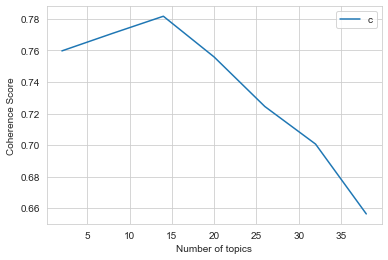

In [34]:
limit=40; start=2; step=6
x=range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
for m, cv in zip(x, coherence_values):
    print("Number of topics: ", m, "has coherence value of", round(cv,4))

Number of topics:  2 has coherence value of 0.7597
Number of topics:  8 has coherence value of 0.7709
Number of topics:  14 has coherence value of 0.7817
Number of topics:  20 has coherence value of 0.7559
Number of topics:  26 has coherence value of 0.7245
Number of topics:  32 has coherence value of 0.7006
Number of topics:  38 has coherence value of 0.6563


The graph above shows the change in coherence score by the number of topics specified in the model.  Coherence rises from about 0.75 for 2 topics to about 0.78 for 8 topics.  After this point the coherence score drops as the number of topics increases.  My original selection of 6 topics appears to provide near-optimal results but, I'll select the LDA model created with 8 topics and long (full ICD-10 code) bi-grams moving forward. 

In [36]:
best_model = model_list[1]
best_topics = best_model.show_topics(formatted=False)
pprint(best_model.print_topics(num_words=10))

[(0,
  '0.068*"I48_J18" + 0.053*"J18_J80" + 0.042*"E14_I48" + 0.039*"E66_E78" + '
  '0.039*"J18_J90" + 0.031*"I48_N18" + 0.030*"I35_I48" + 0.027*"J18_N39" + '
  '0.027*"K72_N19" + 0.026*"E11_J44"'),
 (1,
  '0.079*"E14_E66" + 0.050*"K72_N17" + 0.048*"E14_F03" + 0.045*"N18_N28" + '
  '0.034*"E11_F01" + 0.029*"A49_J18" + 0.027*"N00_N18" + 0.026*"I71_J44" + '
  '0.026*"F03_I25" + 0.026*"K74_K76"'),
 (2,
  '0.186*"C78_C78" + 0.095*"N17_N18" + 0.054*"J44_N18" + 0.053*"E11_E78" + '
  '0.049*"E14_J44" + 0.047*"C78_C79" + 0.030*"J18_N28" + 0.029*"K92_N17" + '
  '0.018*"I27_I48" + 0.018*"E14_F01"'),
 (3,
  '0.097*"I48_J44" + 0.039*"E14_I25" + 0.037*"E11_F03" + 0.036*"E11_I48" + '
  '0.035*"G93_I45" + 0.034*"G93_J18" + 0.032*"G93_I48" + 0.028*"I21_N17" + '
  '0.028*"A49_G93" + 0.026*"J44_J69"'),
 (4,
  '0.057*"E66_G47" + 0.054*"G30_I48" + 0.049*"E11_E66" + 0.040*"I21_I25" + '
  '0.037*"E78_J44" + 0.030*"E78_F03" + 0.030*"I48_N17" + 0.030*"E03_E78" + '
  '0.027*"I25_J44" + 0.027*"E78_I71"'),
 (5,


**Assigning dominant topic to each record based on ICD-10 codes**  Each death record that contains multiple ICD-10 codes in the underlying and multiple cause fields consists of multiple topics, some more dominant than others.  In the following step, I select the most salient topic for each record and label it with that topic.

In [37]:
## create function to attach dominant topic to each record

def label_records(ldamodel=ldamodel_bi_long, corpus=corpus_bi_long, texts=ds.bigrams_long):
    
    #Initial ouput
    sent_topics_df = pd.DataFrame()
    
    #get main topic for each record
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # get the dominant topic, percent contribution, and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: #=> dominant topic
                wp = ldamodel_bi_long.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
        sent_topics_df.columns = ['Dominant Topic', 'Percent_contribution', 'Topic_Keywords']
        
        #add original list of ICD-10 codes to end of output
        contents = pd.Series(texts)
        
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
        return(sent_topics_df)
    

    

In [38]:
df_topic_sents_keywords = label_records(ldamodel = best_model, corpus=corpus_bi_long, texts=ds['bigrams_long'])    

#format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_topic', 'Topic_percent_contribution', 'Keywords', 'Text']
            
#show topics

df_dominant_topic.head(10)

,Document_No,Dominant_topic,Topic_percent_contribution,Keywords,Text
0,0,0.0,0.125,"J189_N179, I48_J189, G309_I48, C795_C798, C780...",NaN
1,3,NaN,NaN,NaN,[]
2,4,NaN,NaN,NaN,"[F54_G729, G729_W80]"
3,38,NaN,NaN,NaN,"[D469_I802, I802_J189, J189_Y831]"
4,45,NaN,NaN,NaN,"[B182_C786, C786_N179]"
5,69,NaN,NaN,NaN,"[A310_I120, I120_I48, I48_J449, J449_K922, K92..."
6,70,NaN,NaN,NaN,[F03_J189]
7,90,NaN,NaN,NaN,[]
8,119,NaN,NaN,NaN,[I080_I471]
9,160,NaN,NaN,NaN,"[C787_C795, C795_M844, M844_N288]"


The labelling step appears not to work in this instance.  Latent Dirichlet Allocation used with short text documents (having only a few codes per record) may run into problems assigning topics to individual documents while it can still identify topics over the entire corpus in general.

One potential solution to this problem is to use a corpus that contains both garbage coded and an equal number of randomly selected records that have valid codes. The theory here is that the patterns in multiple cause codes associated with known, valid underlying cause codes may provide additional information for the algorithm to be able to detect patterns more accurately in both valid and garbage coded records. The assumption underlying this approach is that the sequences and co-occurrence of ICD-10 codes in the multiple cause fields of records with valid codes will also show up in those with garbage codes. I'm not sure how good this assumption is as I suspect the entire cause of death for a record with garbage underlying code suffers from the same poor data quality. However, it's worth a try.

I had hoped to be able to label all garbage coded records with both LDA-based topics and the classifications predicted by the supervised ML models (Linear SVM and Multinomial Naive Bayes) to examine the degree to which the models agreed.  As a future step, I will change the corpus as described in the previous paragraph and use different topic modeling algorithms that may be better suited to short texts.

In [39]:
##Method 1 to get topic probs per doc

all_topics = ldamodel_bi_long.get_document_topics(corpus_bi_long, minimum_probability=0.0) # get all topics from lda model
all_topics_csr = gensim.matutils.corpus2csc(all_topics) # converts Gensim format to scipy.sparse.csc matrix
all_topics_numpy = all_topics_csr.T.toarray()# .T attribute of object transposes it then toarray() converts to np array
all_topics_df = pd.DataFrame(all_topics_numpy) 

In [40]:
all_topics_df.head()

,0,1,2,3,4,5
0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
2,0.374992,0.125002,0.125002,0.125002,0.125002,0.125002
3,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
4,0.106224,0.240244,0.106207,0.106207,0.106207,0.334911


In [41]:
all_topics_df['main_topic'] = all_topics_df.idxmax(axis=1)


In [42]:
all_topics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7797 entries, 0 to 7796
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   0           7797 non-null   float64
 1   1           7797 non-null   float64
 2   2           7797 non-null   float64
 3   3           7797 non-null   float64
 4   4           7797 non-null   float64
 5   5           7797 non-null   float64
 6   main_topic  7797 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 426.5 KB


In [43]:

all_topics_df['flag'] = (all_topics_df[[0, 1, 2, 3, 4]] >= 0.21).any(axis=1)

In [44]:
all_topics_df.loc[all_topics_df['flag']==True, 'LDA_Topic'] = all_topics_df['main_topic']


In [45]:
all_topics_df.head()

,0,1,2,3,4,5,main_topic,flag,LDA_Topic
0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,False,NaN
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,False,NaN
2,0.374992,0.125002,0.125002,0.125002,0.125002,0.125002,0,True,0.0
3,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,False,NaN
4,0.106224,0.240244,0.106207,0.106207,0.106207,0.334911,5,True,5.0


**Additional strategies with LDA for future implementation**

While LDA provides some interesting results, there may be ways of improving on the performance of the models created above. LDA is intended to be used with longer texts relative to the short list of ICD-10 codes for each record. Other variations of and alternatives to LDA, such as Gibbs Sampling Dirichlet Mixture Model (GSDMM) and bi-term topic modeling, are intended to be used for short text topic modeling. GSDMM starts with the assumption that each document contains only one topic which may be more applicable to this use case. Bi-term topic modeling examines pairs of words and their co-occurrence across the corpus in finding topics.

Another approach I'd like to try with the current LDA model is to add a random sample of records with valid underlying cause codes to the corpus. This would increase the amoung of information available to the algorithm. With increasing examples of the distribution of codes within topics and topics across the corpus the classifier may gain accuracy.